In [17]:
import numpy as np
import torch
import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights
from Dataloader import WholeDataset,BaseModel,ResetWeigtsDataset
from torch.utils.data import  DataLoader,SubsetRandomSampler
from sklearn.neighbors import KNeighborsClassifier
from Config import config,Args
from Metrics import ComputeMetrics
from sklearn.model_selection import KFold
from tqdm import tqdm
from models.DimRed import zca_whitening_matrix
import math
from sklearn.neighbors import KernelDensity

In [18]:
args_train = Args("train")
train_dataset = WholeDataset(args_train)
args_test  = Args("test")
test_dataset = WholeDataset(args_test)

train_dataset = ResetWeigtsDataset("ResnetFeaturesTrain.pt","train")
test_dataset = ResetWeigtsDataset("ResnetFeaturesTest.pt","test")

train_dataloader = DataLoader(train_dataset,shuffle=True,batch_size=40000,num_workers=4,pin_memory=True,persistent_workers=True)
test_dataloader = DataLoader(test_dataset,shuffle=False,batch_size=2000,num_workers=4,pin_memory=True,persistent_workers=True)
X_t,y_t,s_t = next(iter(train_dataloader))#train_dataset[:1000]
X_v,y_v,s_v = next(iter(test_dataloader))#test_dataset[:1000] 
#X_t= X_t.flatten(start_dim=1)
#X_v =  X_v.flatten(start_dim=1)

In [25]:
train_dataset[[1,2]]

ValueError: pic should be 2/3 dimensional. Got 4 dimensions.

In [15]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_t,y_t)

KNeighborsClassifier()

In [18]:
y_pred = knn.predict(X_v) 

/research/hal-gaudisac/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [19]:
compute_metrics(torch.tensor(y_pred),y_v)

({'f1': tensor([0.5921, 0.6313, 0.2920, 0.3556, 0.3514, 0.3308, 0.2200, 0.3140, 0.3103,
          0.2613]),
  'accuracy': tensor([0.5294, 0.8492, 0.1724, 0.2991, 0.2364, 0.2529, 0.1264, 0.1919, 0.2022,
          0.7979]),
  'precesion': tensor([0.6716, 0.5023, 0.9524, 0.4384, 0.6842, 0.4783, 0.8462, 0.8636, 0.6667,
          0.1562]),
  'recall': tensor([0.5294, 0.8492, 0.1724, 0.2991, 0.2364, 0.2529, 0.1264, 0.1919, 0.2022,
          0.7979]),
  'confmat': tensor([[ 45,   0,   0,  12,   0,   2,   0,   0,   0,  26],
          [  0, 107,   0,   0,   0,   0,   0,   0,   0,  19],
          [  7,  32,  20,   7,   0,   2,   0,   1,   0,  47],
          [  0,  12,   1,  32,   0,  10,   0,   0,   4,  48],
          [  0,   8,   0,   1,  26,   0,   1,   0,   0,  74],
          [  4,   5,   0,   4,   0,  22,   0,   0,   5,  47],
          [ 10,   8,   0,   0,   4,   7,  11,   0,   0,  47],
          [  0,  23,   0,   0,   1,   0,   0,  19,   0,  56],
          [  1,  10,   0,  14,   1,   3,   1

In [2]:
from Dataloader import ClassConditionalPermutation

In [3]:
classCondPerm = ClassConditionalPermutation(0.2)

In [7]:
train_dataloader = DataLoader(train_dataset,shuffle=True,batch_size=1000,num_workers=4,pin_memory=True,persistent_workers=True)
test_dataloader = DataLoader(test_dataset,shuffle=False,batch_size=1000,num_workers=4,pin_memory=True,persistent_workers=True)
X_t,l_t,y_t,s_t = next(iter(train_dataloader))#train_dataset[:1000]
X_v,l_v,y_v,s_v = next(iter(test_dataloader))#test_dataset[:1000] 
U = classCondPerm(X_t,y_t)

/research/hal-gaudisac/project802/Dataloader.py:107: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /opt/conda/conda-bld/pytorch_1674893616450/work/torch/csrc/utils/tensor_numpy.cpp:206.)
  label_image = torch.from_numpy(np.transpose(label_image,(2,0,1)))
/research/hal-gaudisac/project802/Dataloader.py:107: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internal

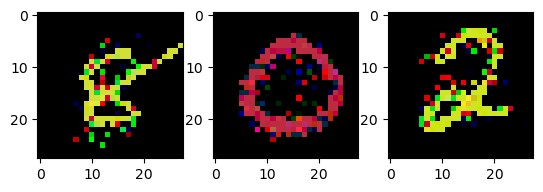

In [12]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,3)
ax[0].imshow(np.transpose((U[y_t==8] )[1],(1,2,0)))
ax[1].imshow(np.transpose((U[y_t==0] )[1],(1,2,0)))
ax[2].imshow(np.transpose((U[y_t==2] )[1],(1,2,0)))
fig.show()

In [19]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from Metrics import ComputeMetrics
compute_metrics =ComputeMetrics(10)
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X_t, y_t)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto'))])

In [31]:
l=[]
for X_v,y_v,s_v in iter(test_dataloader):
    Xv_flat  = X_v.flatten(start_dim=1)
    y_pred = clf.predict(Xv_flat)
    metrics = compute_metrics(torch.tensor(y_pred),y_v)
    l.append(metrics)

In [35]:
u =[]
for metric in l:
    u.append(metric[1]["recall"].item())
u = np.array(u)
u.mean(),np.sqrt(u.var())

(0.41508861184120177, 0.0077237196693616325)

In [36]:
l=[]
for X_v,y_v,s_v in iter(train_dataloader):
    Xv_flat  = X_v.flatten(start_dim=1)
    y_pred = clf.predict(Xv_flat)
    metrics = compute_metrics(torch.tensor(y_pred),y_v)
    l.append(metrics)
    break

In [37]:
u =[]
for metric in l:
    u.append(metric[1]["accuracy"].item())
u = np.array(u)
u.mean(),np.sqrt(u.var())

(0.8958479166030884, 0.0)

: 

In [30]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(X_t, y_t)

/research/hal-gaudisac/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
